In [25]:
!pip3 install graphviz


[notice] A new release of pip is available: 25.0 -> 25.0.1
[notice] To update, run: pip install --upgrade pip


In [13]:
from graphviz import Digraph

def trace(root):
  # builds a set of all nodes and edges in a graph
  nodes, edges = set(), set()
  def build(v):
    if v not in nodes:
      nodes.add(v)
      for child in v._prev:
        edges.add((child, v))
        build(child)
  build(root)
  return nodes, edges

def draw_dot(root):
  dot = Digraph(format='svg', graph_attr={'rankdir': 'LR'}) # LR = left to right
  
  nodes, edges = trace(root)
  for n in nodes:
    uid = str(id(n))
    # for any value in the graph, create a rectangular ('record') node for it
    dot.node(name = uid, label = "{ %s | data %.4f | grad %.4f }" % (n.label, n.data, n.grad), shape='record')
    if n._op:
      # if this value is a result of some operation, create an op node for it
      dot.node(name = uid + n._op, label = n._op)
      # and connect this node to it
      dot.edge(uid + n._op, uid)

  for n1, n2 in edges:
    # connect n1 to the op node of n2
    dot.edge(str(id(n1)), str(id(n2)) + n2._op)

  return dot


In [29]:
class Value:
    def __init__(self, data, _children = (), _op='', label='', grad = 0.0):
        self.data = data
        self._prev = set(_children) # used to store which Values were used to get this data
        self._op = _op # which operation was run on the children Values to get this data
        self.label = label # what should it be known as in the graph vis (just the var name usually)
        self.grad = grad # what is the gradient wrt to the final root node

    def __repr__(self):
        return f"Value (data = {self.data})"

    def __add__(self, other):
        return Value(self.data + other.data, (self, other), '+')

    def __mul__(self, other):
        return Value(self.data * other.data, (self, other), '*')
        

In [18]:
a = Value(2.0, label='a')
b = Value(-3.0, label='b')
c = Value(10.0, label='c')
e = a * b; e.label = 'e'
d = e + c; d.label = 'd'
f = Value(-2.0, label='f')
L = f * d; L.label = 'L'

In [20]:
L.grad = 1.0 # Root node will always have grad = 1 as run over rise over itself is always 1

In [21]:
# When there is multiplication, the grad of the var will be the value of the var it's getting multiplied by
f.grad = 4.0
d.grad = -2.0 

In [22]:
# Following the chain rule, de/dL = (de/dd) * (dd/dL)
# In case of addition (d = e + c), local grad will always be 1
# So here, de/dd = 1, so, de/dL will just be dd/dL

In [23]:
e.grad = -2.0
c.grad = -2.0

In [27]:
# Following the chain rule, da/dL will be (da/de) * (de/dL)
# In multiplication, local grad is the the value of the other val
a.grad = -3.0 * -2.0
b.grad = 2.0 * -2.0

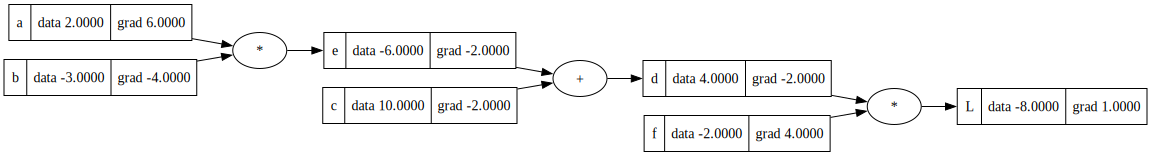

In [28]:
draw_dot(L)

In [ ]:
6-SingleOptimisationStep